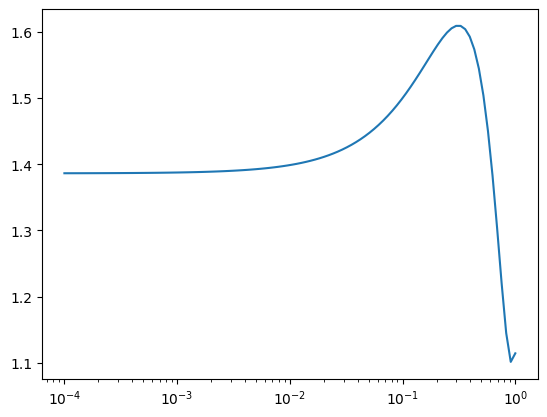

In [17]:
import torch
import matplotlib.pyplot as plt

objective = lambda x: (torch.sin(3.14 * 1.6 * x)+ 4).log()

test_x = torch.logspace(-4, 0, 100)
test_y = objective(test_x)
plt.plot(test_x, test_y)
plt.xscale('log')

In [ ]:
import torch.utils
import torch.utils.data
from src.dl.resnet import CustomResNet
import torchvision
from tqdm import tqdm
from src.dl.trainer import Hyperparameters, FashionMNISTTrainer

torch.set_num_threads(16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomResNet()
trainer = FashionMNISTTrainer(model=model)

def objective(lr: torch.Tensor) -> torch.Tensor:
    torch.manual_seed(0)
    hyperparams = Hyperparameters(epochs=15, learning_rate=lr.item(), batch_size=128)
    return trainer.train_and_test(hyperparams).unsqueeze(0).detach().cpu().double()

# objective(torch.tensor(0.02))

Testing: 100%|██████████| 79/79 [00:00<00:00, 152.27it/s]


(0.0, 1.0)

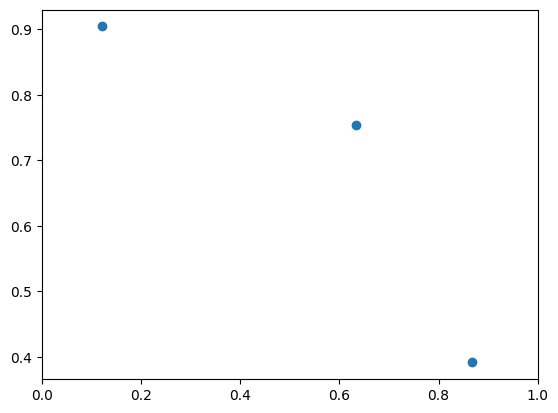

In [3]:
train_x = torch.zeros(3).double()
train_y = torch.zeros(3).double()
sobol = torch.quasirandom.SobolEngine(1, scramble=True)

for i in range(3):
    lr = sobol.draw(1)[0].double()
    train_x[i] = lr.item()
    train_y[i] = objective(lr).item()
plt.scatter(train_x, train_y)
plt.xlim(0, 1)
# plt.plot(test_x, test_y, "--")

Testing: 100%|██████████| 79/79 [00:00<00:00, 163.80it/s]


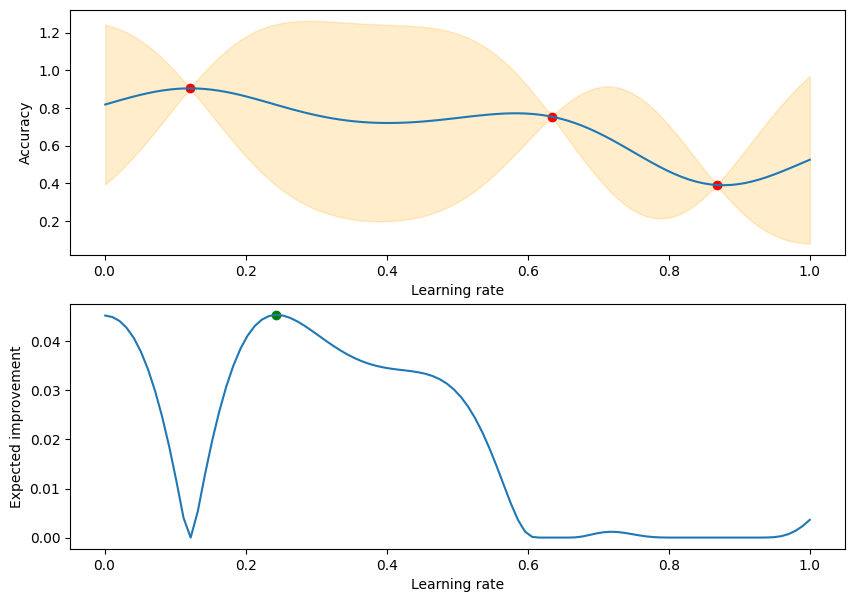

Testing: 100%|██████████| 79/79 [00:00<00:00, 177.85it/s]


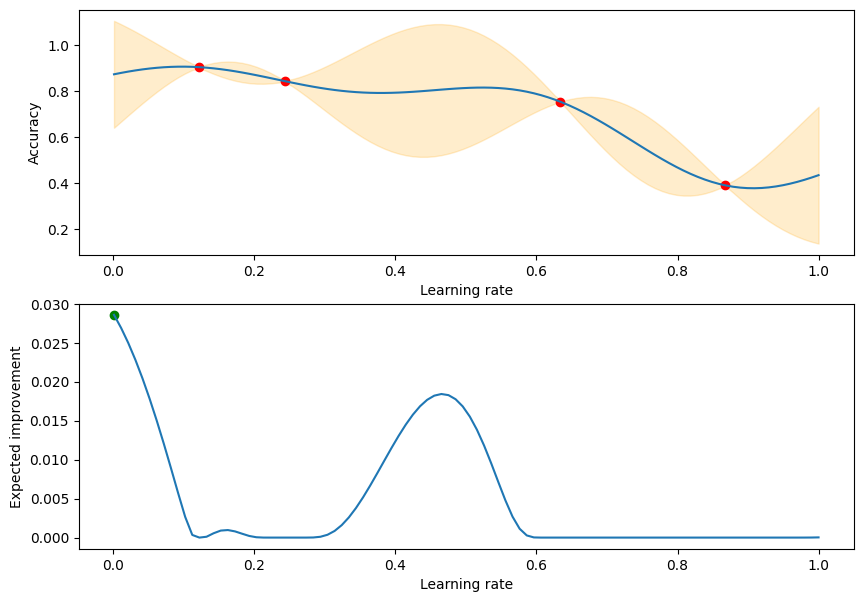

Testing: 100%|██████████| 79/79 [00:00<00:00, 166.46it/s]


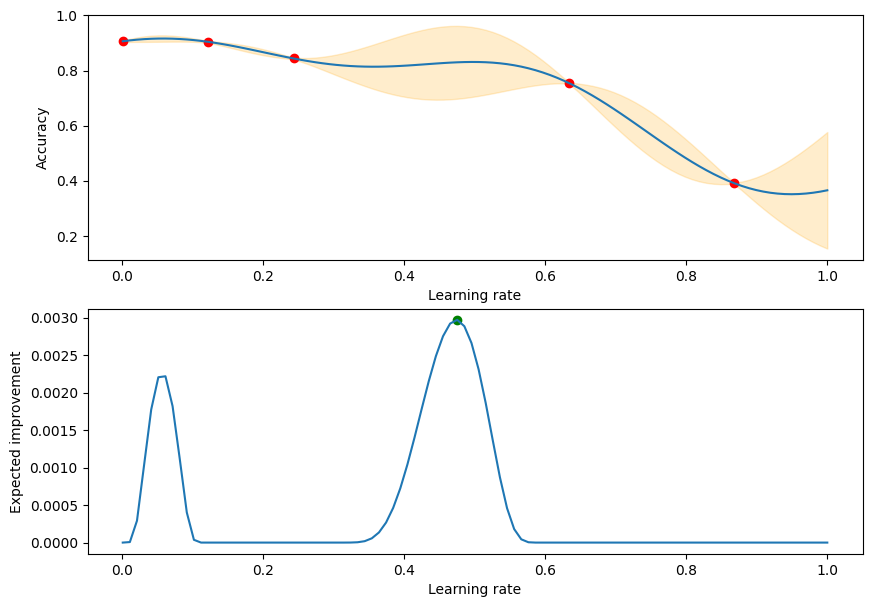

Testing: 100%|██████████| 79/79 [00:00<00:00, 170.40it/s]


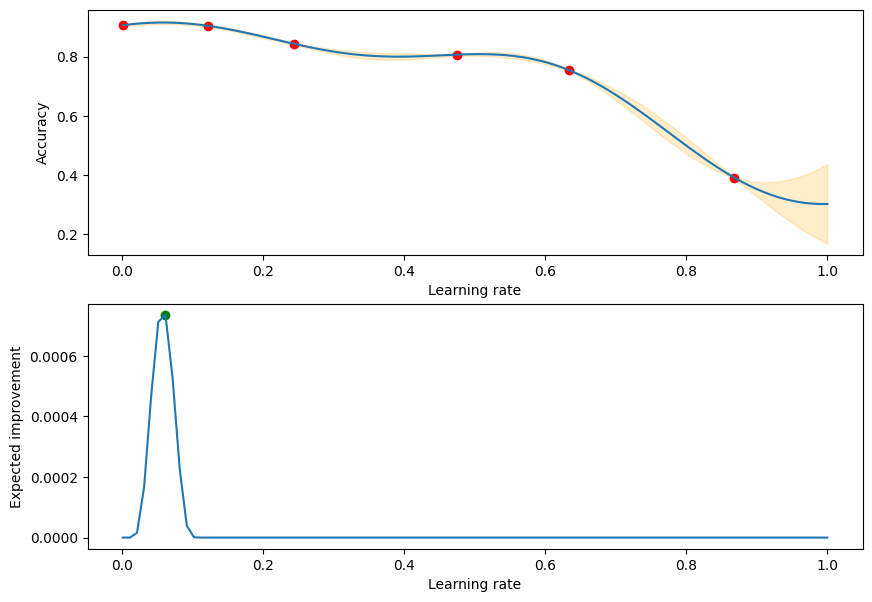

Testing: 100%|██████████| 79/79 [00:00<00:00, 162.94it/s]


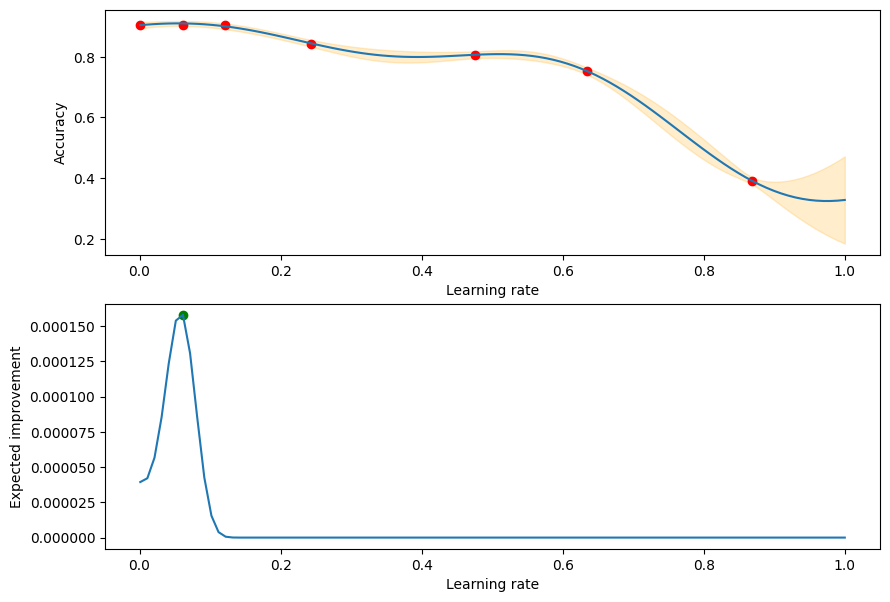

Testing: 100%|██████████| 79/79 [00:00<00:00, 175.19it/s]


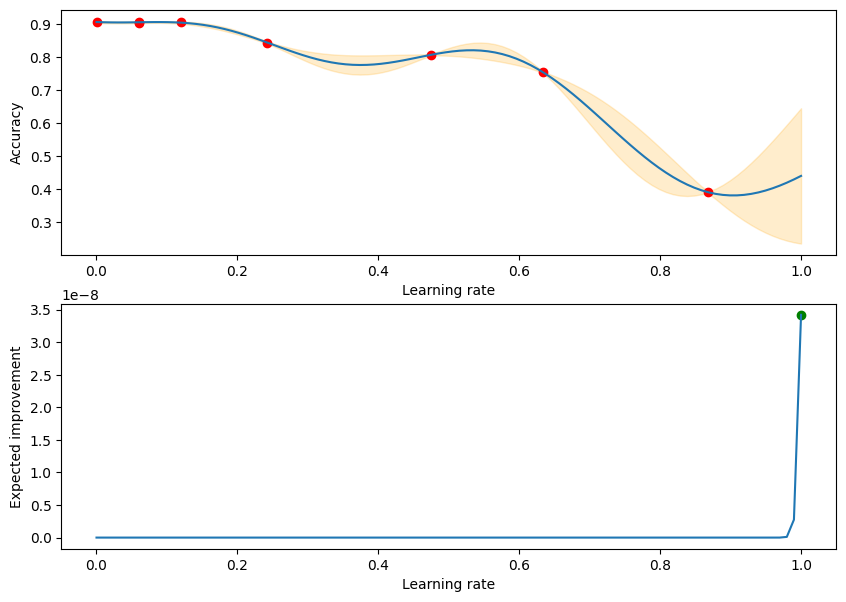

Testing: 100%|██████████| 79/79 [00:00<00:00, 177.86it/s]


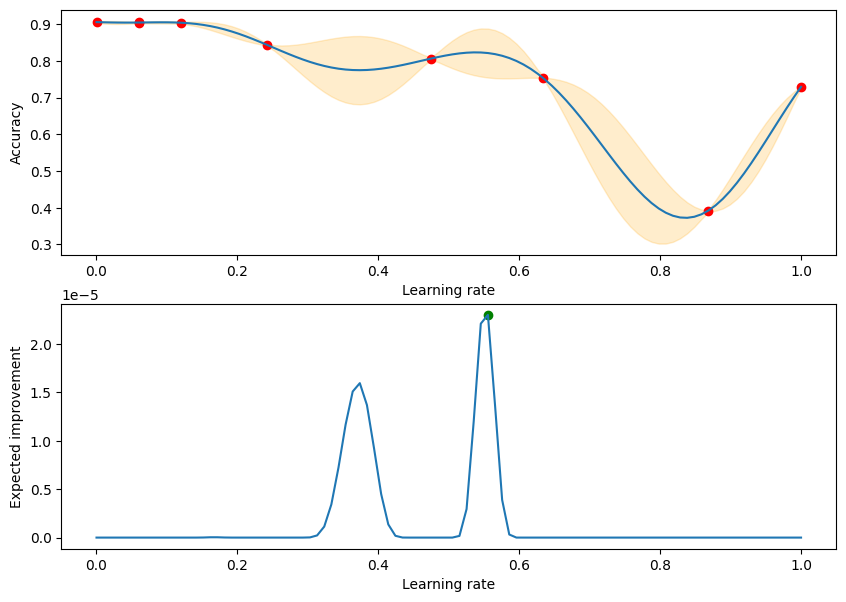

In [4]:
import warnings
from src.bayesian_optim.gaussian_process import GaussianProcess
from src.bayesian_optim.acquisition import CustomExpectedImprovement

train_x = train_x[:3]  # just incase we rerun
train_y = train_y[:3]

warnings.filterwarnings("ignore")

gp_trainer = GaussianProcess()
for _ in range(7):
    grid = torch.linspace(0.001, 1, steps=100).unsqueeze(-1).unsqueeze(-1)

    # GP inference
    gp = gp_trainer.fit(
        train_x=train_x.unsqueeze(-1).double(),
        train_y=train_y.unsqueeze(-1).double(),
    )

    posterior = gp.posterior(grid)
    mean = posterior.mean.detach().squeeze(-1).squeeze(-1)
    std = posterior.variance.sqrt().detach().squeeze(-1).squeeze(-1)

    # Calculate expected improvement and next LR
    ei = CustomExpectedImprovement(model=gp, best_y=train_y.max(), ksi=0.01)
    ei_val = ei(grid)
    next_x = grid[ei_val.argmax()][0].double()
    next_y = objective(next_x)

    # Add new observation to the training set
    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

    # Plotting
    plt.figure(figsize=(10, 7))

    plt.subplot(2, 1, 1)
    plt.plot(grid[:, 0, 0], mean)
    plt.fill_between(
        grid[:, 0, 0], mean - 2 * std, mean + 2 * std, alpha=0.2, color="orange"
    )
    plt.xlabel("Learning rate")
    plt.ylabel("Accuracy")
    plt.scatter(train_x[:-1], train_y[:-1], color="red")
    # plt.plot(test_x, test_y, "--", color="black", alpha=0.3)

    plt.subplot(2, 1, 2)

    plt.plot(grid[:, 0, 0], ei_val.detach())
    plt.scatter(grid[ei_val.argmax(0), 0, 0], ei_val.detach().max(), color="green")
    plt.xlabel("Learning rate")
    plt.ylabel("Expected improvement")
    plt.show()

    # print(grid[ei_val.argmax(0), 0, 0])